# Import

In [1]:
import os, sys

import pandas as pd
import polars as pl
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import sklearn
import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import dproc, sgml, sgnn, sgutil, sgpp

print(sys.version)

for i in [pd, pl, np, mpl, sns, lgb, cb, xgb]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

2025-01-14 02:27:28.284916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736821648.297268   14375 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736821648.300875   14375 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 02:27:28.312792: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]
pandas 2.2.3
polars 1.12.0
numpy 1.26.4
matplotlib 3.8.4
seaborn 0.13.2
catboost 1.2.5
xgboost 2.1.2


In [2]:
for i in ['data', 'result', 'model', 'img']:
    if not os.path.exists(i):
        os.mkdir(i)

data_path = 'data'
def  get_data_path(name):
    return os.path.join(data_path, name)

if not os.path.exists(get_data_path('train.csv')):
    !kaggle competitions download -c playground-series-s4e8
    !unzip playground-series-s4e8.zip -d data

sc = sgutil.SGCache('img', 'result')

In [3]:
from io import StringIO
df_var_info = pd.read_csv(
    StringIO("""name	role	type	description
    poisonous	Target	Categorical	
    cap-shape	Feature	Categorical	bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
    cap-surface	Feature	Categorical	fibrous=f,grooves=g,scaly=y,smooth=s
    cap-color	Feature	Binary	brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
    bruises	Feature	Categorical	bruises=t,no=f
    odor	Feature	Categorical	almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
    gill-attachment	Feature	Categorical	attached=a,descending=d,free=f,notched=n
    gill-spacing	Feature	Categorical	close=c,crowded=w,distant=d
    gill-size	Feature	Categorical	broad=b,narrow=n
    gill-color	Feature	Categorical	black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
    stalk-shape	Feature	Categorical	enlarging=e,tapering=t
    stalk-root	Feature	Categorical	bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?
    stalk-surface-above-ring	Feature	Categorical	fibrous=f,scaly=y,silky=k,smooth=s
    stalk-surface-below-ring	Feature	Categorical	fibrous=f,scaly=y,silky=k,smooth=s
    stalk-color-above-ring	Feature	Categorical	brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
    stalk-color-below-ring	Feature	Categorical	brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
    veil-type	Feature	Binary	partial=p,universal=u
    veil-color	Feature	Categorical	brown=n,orange=o,white=w,yellow=y
    ring-number	Feature	Categorical	none=n,one=o,two=t
    ring-type	Feature	Categorical	cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
    spore-print-color	Feature	Categorical	black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y
    population	Feature	Categorical	abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y
    habitat	Feature	Categorical	grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d"""),
    sep = '\t'
).assign(
    name = lambda x: x['name'].str.strip()
)
df_var_info.set_index('name', inplace=True)

In [4]:
if not os.path.exists(get_data_path('train.parquet')):
    df_type = dproc.merge_type_df(
        [pl.scan_csv(get_data_path(i)).pipe(dproc.get_type_df) for i in ['train.csv', 'test.csv']]
    )
    pl_type = dproc.get_type_pl(df_type)
    pl.scan_csv(get_data_path('train.csv'), schema_overrides =  pl_type).sink_parquet(
        get_data_path('train.parquet')
    )
    pl.scan_csv(get_data_path('test.csv'), schema_overrides =  pl_type).sink_parquet(
        get_data_path('test.parquet')
    )
    df_type['dtype'] = df_type.index.to_series().map(pd.Series(pl_type).astype(str))
    df_type.join(df_var_info, how = 'left').assign(
        description = lambda x: x['description'].fillna("Kaggle created")
    ).to_csv(get_data_path('var.csv'))
df_var = pd.read_csv(get_data_path('var.csv'), index_col = 'feature')

In [5]:
target = 'class'
df_train = pd.read_parquet(get_data_path('train.parquet')).set_index('id')
df_test = pd.read_parquet(get_data_path('test.parquet')).set_index('id')
df_var.drop(index = ['id', target], inplace=True)

In [6]:
X_cat = df_var.query('dtype == "Categorical"').index.tolist()
X_num = df_var.loc[df_var['dtype'].str.startswith('Float')].index.tolist()
len(X_cat) + len(X_num), df_train.shape, df_test.shape

(20, (3116945, 21), (2077964, 20))

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

# Target

In [8]:
pd.concat([
    df_train[target].value_counts().rename('count'),
    df_train[target].value_counts(normalize=True).rename('ratio')
], axis = 1)

,count,ratio
class,,
p,1705396,0.547137
e,1411549,0.452863


# Categorical Variables

모두 명목형 변수로 보이고, 모든 변수가 노이즈를 포함하고 있으며, 노이즈 변수는 빈도수가 낮은 변수들로 보입니다.

이를 정리해주는 청소 작업이 필요합니다.

## Cleaning data

In [9]:
ct_cat = ColumnTransformer([
    ('caf', sgpp.CatArrangerFreq(min_frequency = 100, unknown_value = 'Unk', na_value = 'Unk'), X_cat)
]).set_output(transform='pandas')
ct_cat.fit(df_train[X_cat])
df_cat = ct_cat.transform(df_train[X_cat])

## Descriptive

In [10]:
from scipy.stats import chi2_contingency
from scipy.spatial.distance import pdist, squareform

In [11]:
sc.cache_result(
    'cat_desc',
    lambda : pd.concat([
        (df_cat == 'Unk').sum().rename('Missing'),
        (df_cat == 'Unk').mean().rename('Missing_ratio'),
        df_cat.nunique().rename('nunique'),
        df_cat.apply(
            lambda x: pd.Series(chi2_contingency(pd.crosstab(index = x, columns = df_train[target]))[:2], index = ['chi2, stat', 'chi2, pvalue'])
        ). T
    ], axis = 1), rerun = 0
).sort_values(['chi2, pvalue', 'chi2, stat'], ascending = [True, False])

,Missing,Missing_ratio,nunique,"chi2, stat","chi2, pvalue"
caf__cap-color,12,0.000004,13,208330.755462,0.0
caf__stem-color,38,0.000012,14,206317.990440,0.0
caf__cap-surface,671023,0.215282,12,199240.232405,0.0
caf__gill-attachment,523936,0.168093,8,169648.606124,0.0
caf__stem-surface,1980861,0.635514,9,165450.381251,0.0
caf__gill-color,57,0.000018,13,150819.253763,0.0
caf__ring-type,128880,0.041348,9,127904.172985,0.0
caf__stem-root,2757023,0.884527,6,99319.103129,0.0
caf__habitat,45,0.000014,9,98305.404472,0.0
caf__veil-color,2740947,0.879370,7,92316.923415,0.0


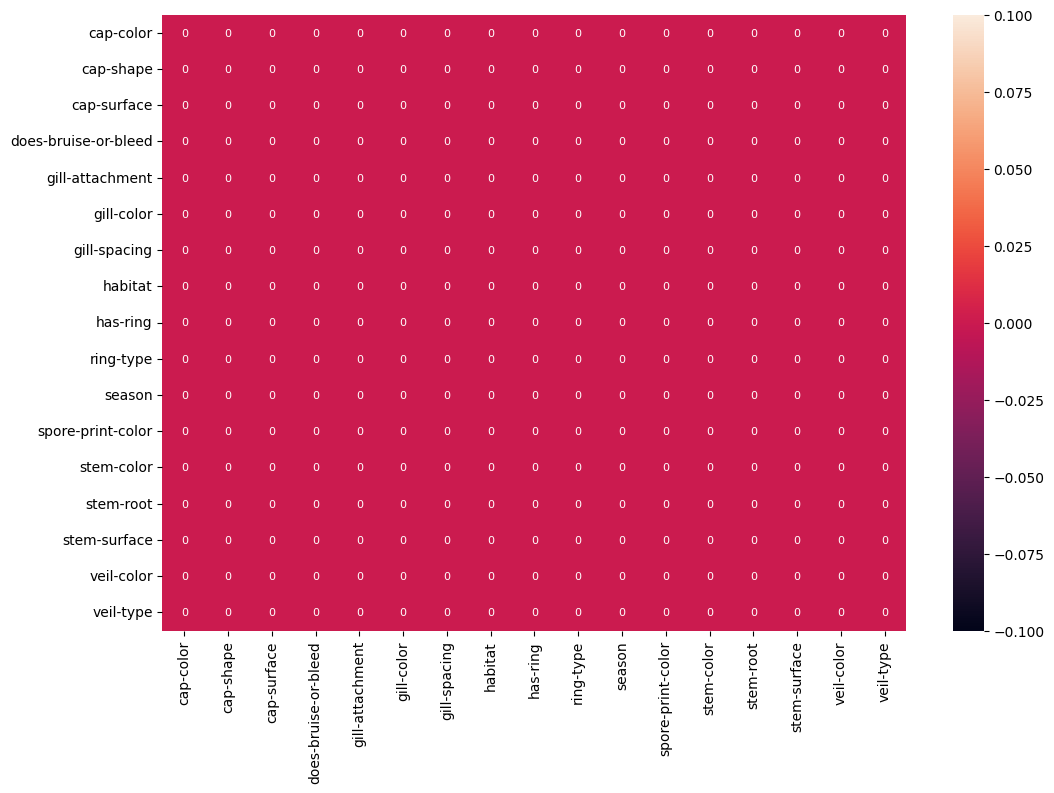

In [12]:
plt.figure(figsize = (12, 8))
sns.heatmap(
    pd.DataFrame(
        squareform(
            sc.cache_result(
                'chi2_cat_var',
                lambda : pdist(df_cat.T, lambda u, v: chi2_contingency(pd.crosstab(index=u, columns=v))[1]),
                rerun = 0
            )
        ), index = X_cat, columns = X_cat
    ), annot = True, annot_kws = {'size': 8}
)
plt.show()

모든 속성이 연관성이 높습니다.

범주형 변수의 가짓수에 비해 등장하는 종류는 적습니다.

In [13]:
df_cat.nunique().prod()

128184423284736

In [14]:
df_cat.value_counts().size

107637

# Numeric Variables

## Cleaning Data

cap-diameter, stem-height에 약간의 결측치들이 있습니다. 최빈값으로 대체합니다.

In [15]:
from sklearn.impute import SimpleImputer
ct_num = ColumnTransformer([
    ('simp', SimpleImputer(strategy = 'most_frequent'), ['cap-diameter', 'stem-height']),
    ('pt', 'passthrough', ['stem-width'])
]).set_output(transform='pandas')
df_num = ct_num.fit_transform(df_train)

## Descriptive

In [16]:
from scipy.stats import kruskal

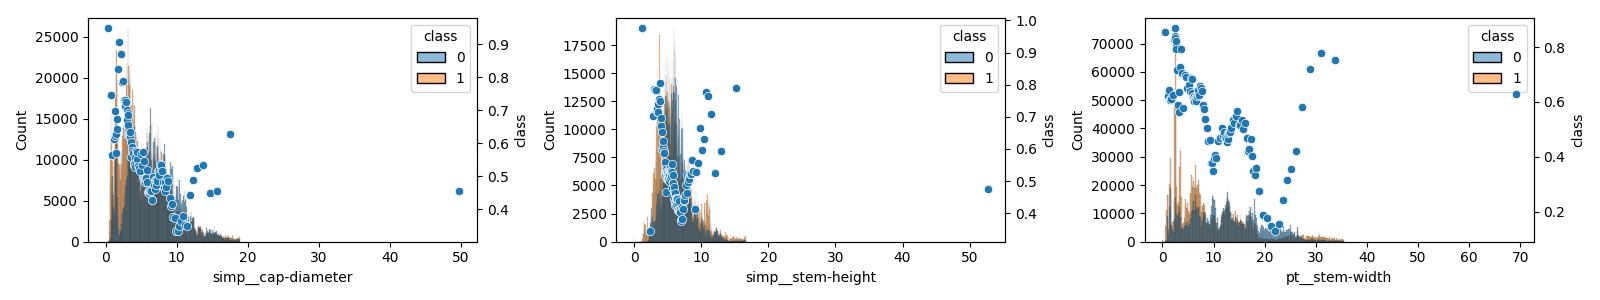

In [17]:
def plot_hist(axes):
    for i, ax in zip(df_num.columns, axes):
        sns.histplot(x = df_num.loc[df_num[i] < df_num[i].quantile(0.99), i], hue = df_train[target], ax=ax)
        df_train.groupby(pd.qcut(df_num[i], q = 100).map(lambda x: (x.left + x.right) / 2), observed=True)[target].mean().pipe(
            lambda x: sns.scatterplot(x, ax = ax.twinx())
        )
sc.cache_fig(
    'hist_num', plot_hist, 1, 3, figsize = (16, 3), redraw = 0
)

In [18]:
df_num.corr()

,simp__cap-diameter,simp__stem-height,pt__stem-width
simp__cap-diameter,1.000000,0.364062,0.746316
simp__stem-height,0.364062,1.000000,0.356225
pt__stem-width,0.746316,0.356225,1.000000


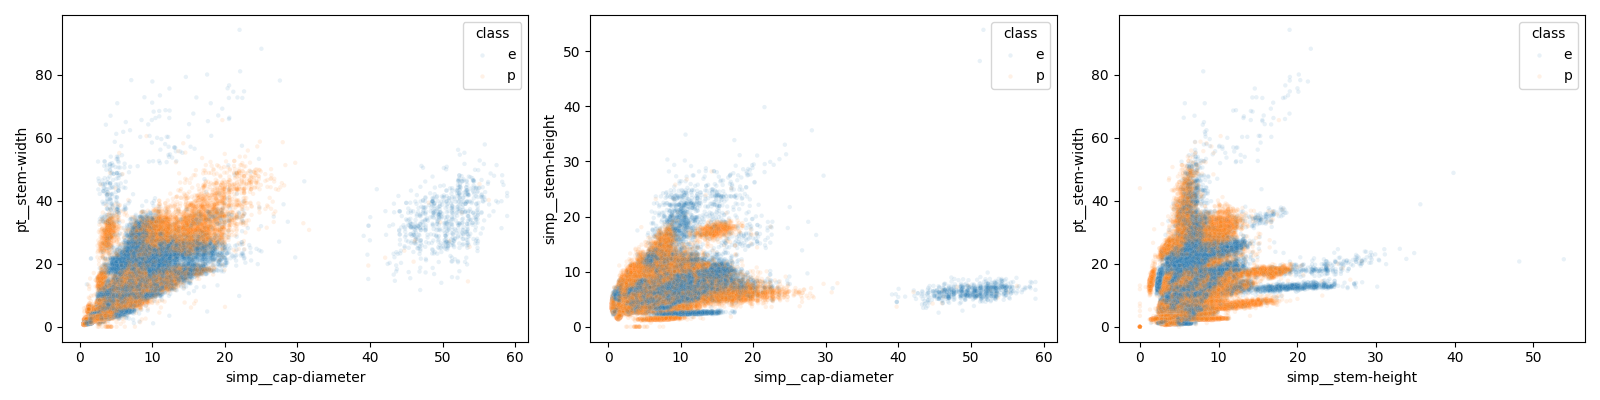

In [19]:
def plot_pair(df, axes):
    for ax, (x, y) in zip(axes, [('simp__cap-diameter', 'pt__stem-width'), ('simp__cap-diameter', 'simp__stem-height'), ('simp__stem-height', 'pt__stem-width')]):
        sns.scatterplot(
            df.join(df_train[target], how='inner'), x = x, y = y, hue = target, alpha = 0.1, s = 10, ax=ax
        )
sc.cache_fig(
    'pair_plot',
    lambda x: plot_pair(df_num.sample(frac = 0.05), x), 1, 3, figsize = (16, 4), redraw = 0
)

In [20]:
sc.cache_result(
    'krus_num_cat',
    lambda : pd.concat([
        df_num.groupby(df_cat[i], observed = True).agg(list).apply(lambda x: kruskal(*x)[0], axis = 0).rename(i)
        for i in df_cat.columns
    ], axis=1)
).T

,simp__cap-diameter,simp__stem-height,pt__stem-width
caf__cap-color,61911.303789,144936.008822,63332.736218
caf__cap-shape,325051.620723,223715.323668,421971.774427
caf__cap-surface,520373.280022,356119.341342,629688.245746
caf__does-bruise-or-bleed,332102.227143,111231.504630,301261.409764
caf__gill-attachment,632916.776770,471446.841571,709624.949633
caf__gill-color,305741.962918,158675.349788,400635.878104
caf__gill-spacing,40589.462621,117220.811239,99659.000277
caf__habitat,300687.999947,92024.616649,315819.986215
caf__has-ring,100227.960793,225550.587875,41788.845336
caf__ring-type,221803.555298,441479.063296,139570.058546


# ML

## Train & Test diff 

In [21]:
import importlib
importlib.reload(sgpp)

<module 'sgpp' from '/home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep8/sgpp.py'>

In [22]:
lbl_enc = LabelEncoder()
lbl_enc.fit(df_train[target])
print(lbl_enc.classes_)
cbt = sgpp.CombineTransformer([
    ('cat', ct_cat),
    ('num', ct_num),
], target, lbl_enc)
df_ml = cbt.transform(df_train)

['e' 'p']


In [23]:
from sklearn.model_selection import cross_val_score, ShuffleSplit

sc.cache_result(
    'train_test_diff',
    lambda : pd.concat([
        df_ml.assign(is_train = True),
        cbt.transform(df_test).assign(is_train = False)
    ], axis = 0).pipe(
        lambda x: cross_val_score(
            lgb.LGBMClassifier(random_state = 123, verbose = -1), x[cbt.get_vars()], x['is_train'], 
            cv = ShuffleSplit(1, train_size = 0.8, random_state = 123), scoring = 'roc_auc', params = {'categorical_feature': cbt.get_vars('cat')}
        )
    ), rerun = 0
)

array([0.50067673])

학습과 평가셋은 구분할 수 없습니다. 테스트셋에만 나타나는 특이 패턴은 없다고 판단 됩니다.

In [24]:
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction, stratify=x[target])

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index = df.index, name = 'p'),
    'score_func': lambda df, prds: matthews_corrcoef(df[target].sort_index(), (prds >= 0.5).sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'y': target
}

ss = ShuffleSplit(n_splits = 1, train_size = 0.6, random_state = 123)

cb_adapter = sgml.CBAdapter(cb.CatBoostClassifier)
lr_adapter = sgml.SklearnAdapter(LogisticRegression)
lgb_adapter = sgml.LGBMAdapter(lgb.LGBMClassifier)

## Analysis using CatBoost

In [25]:
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shap

In [26]:
hparams = {
    'model_params': {'n_estimators': 100, 'random_state': 123},
    'X_num': cbt.get_vars('num'), 'X_cat': cbt.get_vars('cat'),
    'validation_fraction': 0.1, 
}
result = sc.cache_result(
    'feature_imp_iter_cb',
    lambda : sgml.cv(
        df_ml, ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            partial(sgml.gb_shap_learning_result, df=df_ml.sample(frac=0.01, random_state= 123)), 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result['train_scores'], result['valid_scores']

([0.972734320857262], [0.9729621111575812])

In [27]:
confusion_matrix(df_ml.loc[result['valid_prd'].index, target], result['valid_prd'] >= 0.5)

array([[558018,   6697],
       [ 10026, 672037]])

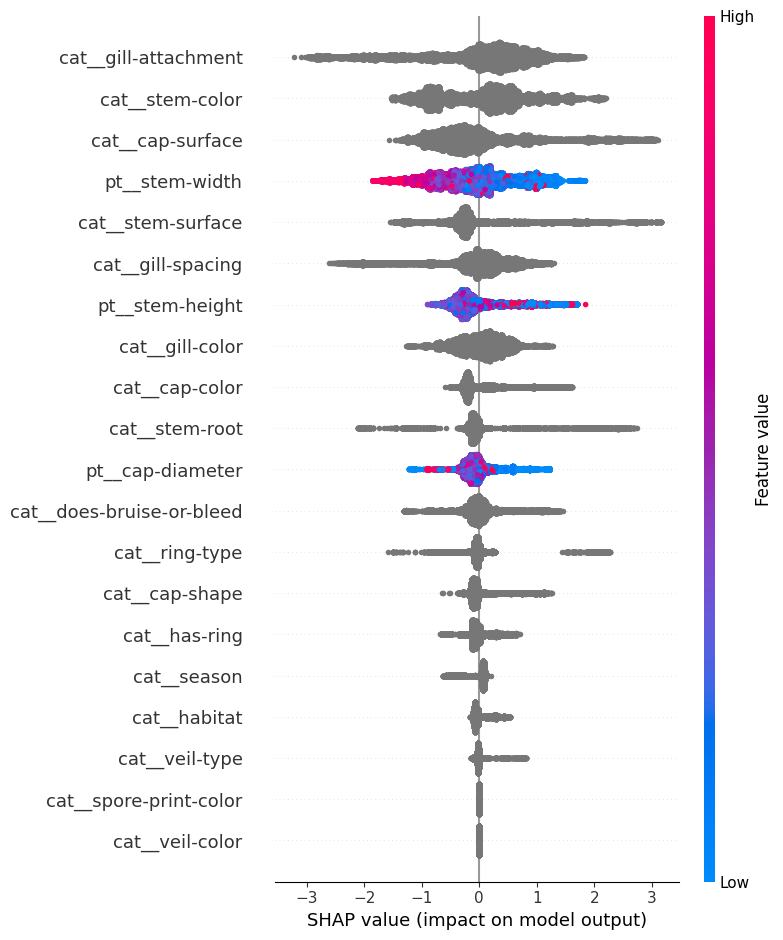

In [28]:
shap.summary_plot(result['model_result'][1]['shap_values'], result['model_result'][1]['X'])

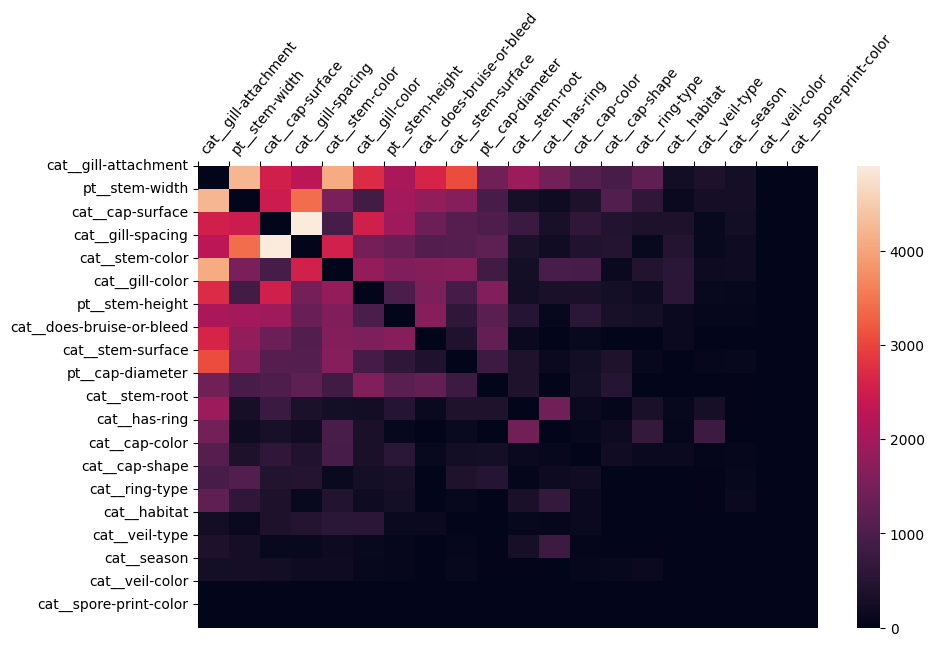

In [29]:
interaction_matrix = np.abs(result['model_result'][1]['shap_interaction_values']).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(10, 6))
sns.heatmap(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

In [30]:
result['model_result'][0]['feature_importance'].sort_values(ascending=False)

cat__gill-attachment         15.323671
cat__cap-surface             11.868529
pt__stem-width               10.330245
cat__gill-spacing             9.346187
cat__stem-color               8.440528
cat__stem-surface             8.271102
pt__stem-height               6.228481
cat__gill-color               6.186547
cat__does-bruise-or-bleed     4.674690
cat__stem-root                4.265687
pt__cap-diameter              4.129154
cat__ring-type                3.157066
cat__cap-color                2.296330
cat__cap-shape                1.848221
cat__has-ring                 1.605820
cat__veil-type                0.852680
cat__habitat                  0.686055
cat__season                   0.489007
cat__spore-print-color        0.000000
cat__veil-color               0.000000
dtype: float64

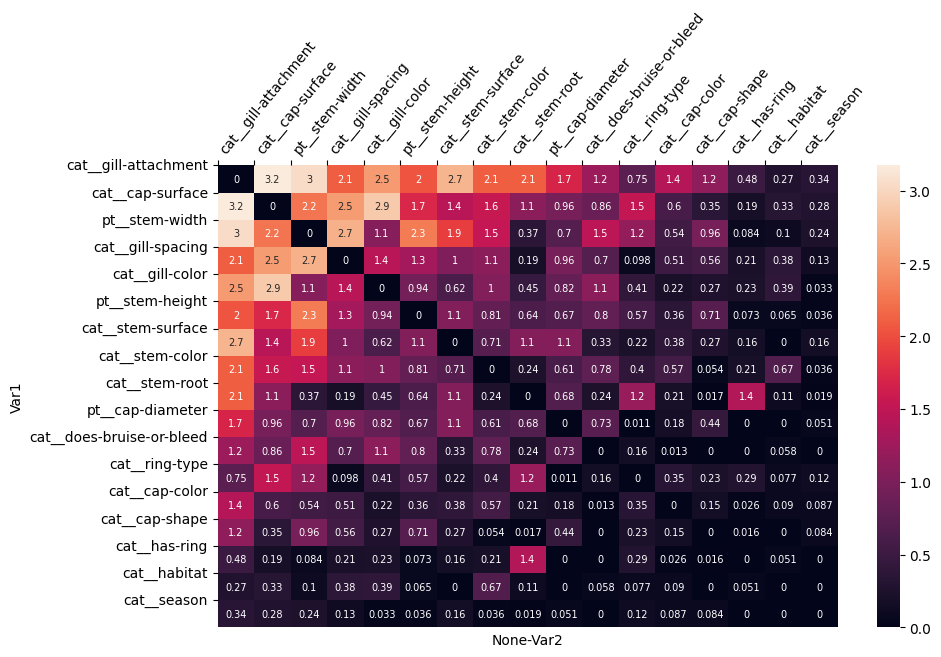

In [31]:
df_cb_inter = pd.concat([
    result['model_result'][2],
    result['model_result'][2].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
sns.heatmap(df_cb_inter, annot=True, annot_kws={'size': 7})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

In [32]:
hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num'), 'X_cat': cbt.get_vars('cat'),
    'validation_fraction': 0.1, 
}
result_base = sc.cache_result(
    'cb_1',
    lambda : sgml.cv(
        df_ml, ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result_base['train_scores'], result_base['valid_scores']

([0.9837681435694359], [0.983356453167922])

In [33]:
confusion_matrix(df_ml.loc[result['valid_prd'].index, target], result_base['valid_prd'] >= 0.5)

array([[560239,   4476],
       [  5811, 676252]])

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df_ml.loc[result_base['valid_prd'].index, target], result_base['valid_prd'])

0.9968894786484909

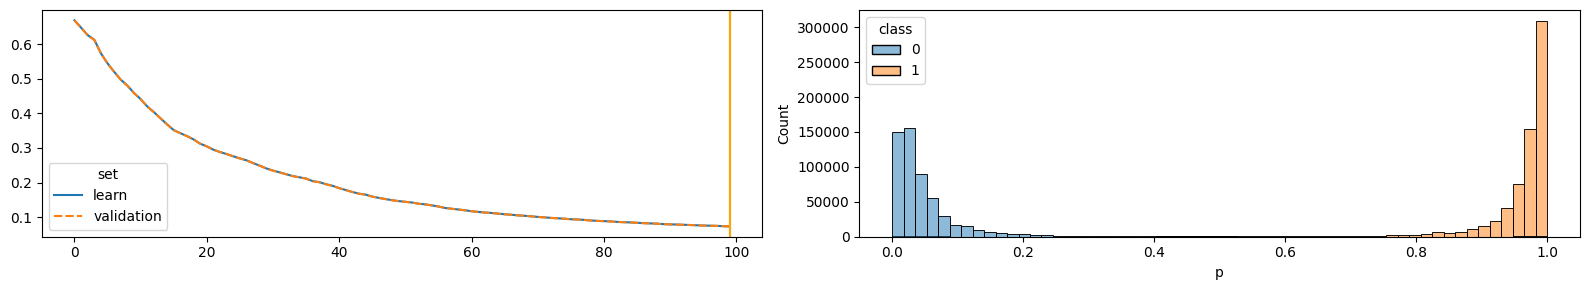

In [35]:
fig, axes= plt.subplots(1, 2, figsize = (16, 3))
sns.lineplot(
    result['model_result'][0]['valid_result'].T.reset_index(level=0, drop=True).T, ax = axes[0]
)
axes[0].axvline(result['model_result'][0]['valid_result'].idxmin().iloc[0])
axes[0].axvline(result['model_result'][0]['valid_result'].idxmin().iloc[1], color = 'orange')

sns.histplot(
    x = result['valid_prd'], hue = df_ml.loc[result['valid_prd'].index, target], ax = axes[1]
)
plt.tight_layout()
plt.show()

In [36]:
result_base['model_result'][0]['feature_importance'].sort_values(ascending = False)

cat__gill-attachment         11.633358
cat__cap-surface             10.936322
pt__stem-width               10.877971
cat__gill-spacing             9.580750
cat__stem-surface             8.292273
cat__stem-color               8.031950
pt__stem-height               6.418610
cat__gill-color               4.966181
pt__cap-diameter              4.565979
cat__stem-root                4.094194
cat__cap-color                4.041382
cat__does-bruise-or-bleed     4.006435
cat__cap-shape                3.900361
cat__has-ring                 2.321098
cat__ring-type                2.171239
cat__season                   1.897975
cat__habitat                  1.271376
cat__veil-type                0.443824
cat__spore-print-color        0.363070
cat__veil-color               0.185654
dtype: float64

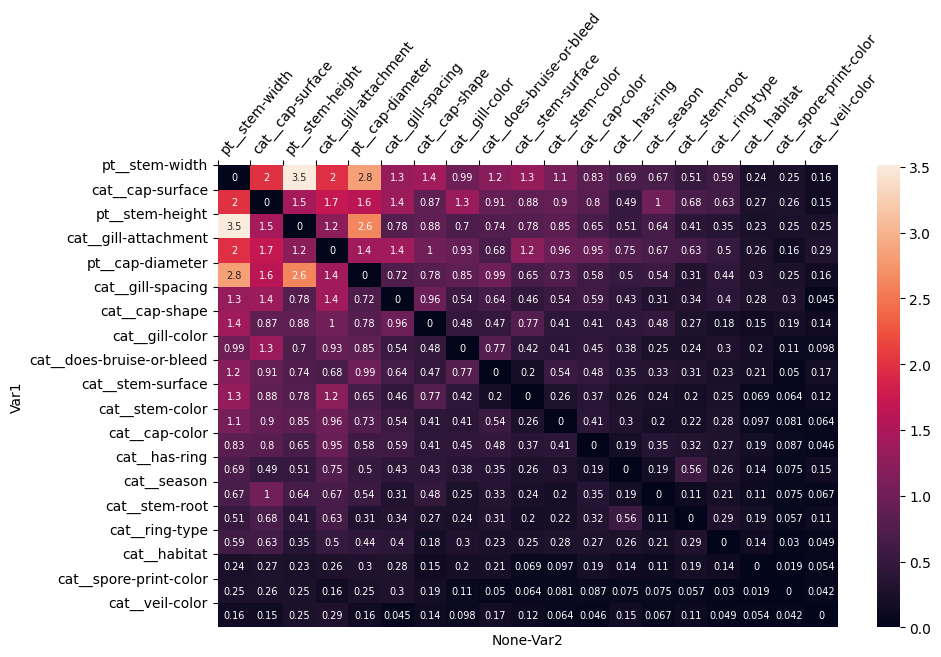

In [37]:
df_cb_inter = pd.concat([
    result_base['model_result'][1],
    result_base['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
sns.heatmap(df_cb_inter, annot=True, annot_kws={'size': 7})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

In [38]:
df_ce = (
    pd.concat([
        -np.log(1 - result['valid_prd']).rename(0),
        -np.log(result['valid_prd']).rename(1), 
    ], axis=1) * pd.get_dummies(df_ml.loc[result_base['valid_prd'].index, target])
).sum(axis=1).rename('ce').to_frame()

In [39]:
from scipy.stats import kruskal
sc.cache_result(
    'kruskal_cat_cb',
    lambda : pd.concat([pd.Series(kruskal(
        *df_ce.groupby(df_ml.loc[df_ce.index, i], observed = True)['ce'].agg(list)
    ), index = ['stat',  'pvalue'], name = i) for i in cbt.get_vars('cat')
    ], axis=1), rerun = 0
).T.sort_values('stat', ascending = False)

,stat,pvalue
cap-surface,95461.125309,0.0
has-ring,93726.688116,0.0
ring-type,82251.974302,0.0
stem-surface,65204.600001,0.0
veil-color,51082.592614,0.0
spore-print-color,50948.960744,0.0
stem-color,44430.830759,0.0
gill-color,42145.796410,0.0
cap-shape,34286.478533,0.0
stem-root,31851.678200,0.0


In [40]:
from scipy.stats import spearmanr

sc.cache_result(
    'spearman_cat_cb', 
    lambda : df_ml.loc[result['valid_prd'].index, cbt.get_vars('num')].apply(
        lambda x: spearmanr(df_ce['ce'], x)[0]
    ), rerun = 0
)

stem-width      0.032850
cap-diameter    0.024026
stem-height    -0.034322
dtype: float64

In [41]:
from scipy.stats import kruskal
sc.cache_result(
    'kruskal_cat_na_cb',
    lambda : pd.concat([pd.Series(kruskal(
        *df_ce.groupby((df_ml.loc[df_ce.index, i] == 'Unk'), observed = True)['ce'].agg(list)
    ), index = ['stat',  'pvalue'], name = i) for i in (df_ml[cbt.get_vars('cat')] == 'Unk').sum().pipe(lambda x: x.loc[x > 100]).index
    ], axis=1), rerun = 0
).T.sort_values('stat', ascending = False)

,stat,pvalue
veil-color,37253.305410,0.000000e+00
spore-print-color,35106.829357,0.000000e+00
stem-surface,30478.934439,0.000000e+00
stem-root,25213.502108,0.000000e+00
ring-type,13442.623016,0.000000e+00
veil-type,11163.484882,0.000000e+00
gill-attachment,10019.967869,0.000000e+00
gill-spacing,944.093213,2.551159e-207
cap-surface,690.453601,3.561653e-152


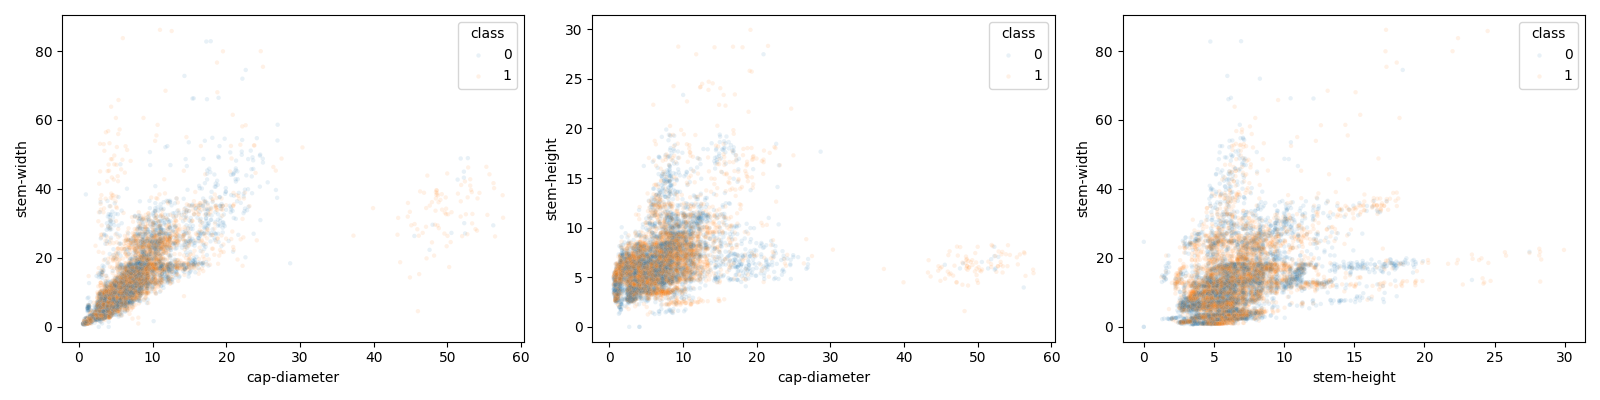

In [42]:
def plot_pair2(df, axes):
    for ax, (x, y) in zip(axes, [('cap-diameter', 'stem-width'), ('cap-diameter', 'stem-height'), ('stem-height', 'stem-width')]):
        sns.scatterplot(
            df, x = x, y = y, hue = target, alpha = 0.1, s = 10, ax=ax
        )
sc.cache_fig(
    'pair_plot2',
    lambda x: plot_pair2(df_ml.loc[result_base['valid_prd'].index].pipe(
        lambda x: x.loc[x[target] != (result_base['valid_prd'] >= 0.5)]
    ), x), 1, 3, figsize = (16, 4), redraw = 0
)

# Feature Engineering

In [43]:
from sklearn.model_selection import cross_validate, StratifiedKFold
df_ml_test = cbt.transform(df_test)

## 수치형 변수를 Target Encoding

In [44]:
X_tgt = ['stem-width', 'cap-diameter', 'stem-height']
hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num'), 'X_cat': cbt.get_vars('cat'), 'X_tgt': [i + '_r' for i in X_tgt],
    'validation_fraction': 0.1, 
}
result_tgt = sc.cache_result(
    'cb_tgt',
    lambda : sgml.cv(
        dproc.join_and_assign(df_ml, df_ml[X_tgt].round(1).rename(columns = lambda x: x + '_r')), ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result['train_scores'], result['valid_scores']

([0.972734320857262], [0.9729621111575812])

In [45]:
result['model_result'][0]['feature_importance'].sort_values(ascending = False)

cat__gill-attachment         15.323671
cat__cap-surface             11.868529
pt__stem-width               10.330245
cat__gill-spacing             9.346187
cat__stem-color               8.440528
cat__stem-surface             8.271102
pt__stem-height               6.228481
cat__gill-color               6.186547
cat__does-bruise-or-bleed     4.674690
cat__stem-root                4.265687
pt__cap-diameter              4.129154
cat__ring-type                3.157066
cat__cap-color                2.296330
cat__cap-shape                1.848221
cat__has-ring                 1.605820
cat__veil-type                0.852680
cat__habitat                  0.686055
cat__season                   0.489007
cat__spore-print-color        0.000000
cat__veil-color               0.000000
dtype: float64

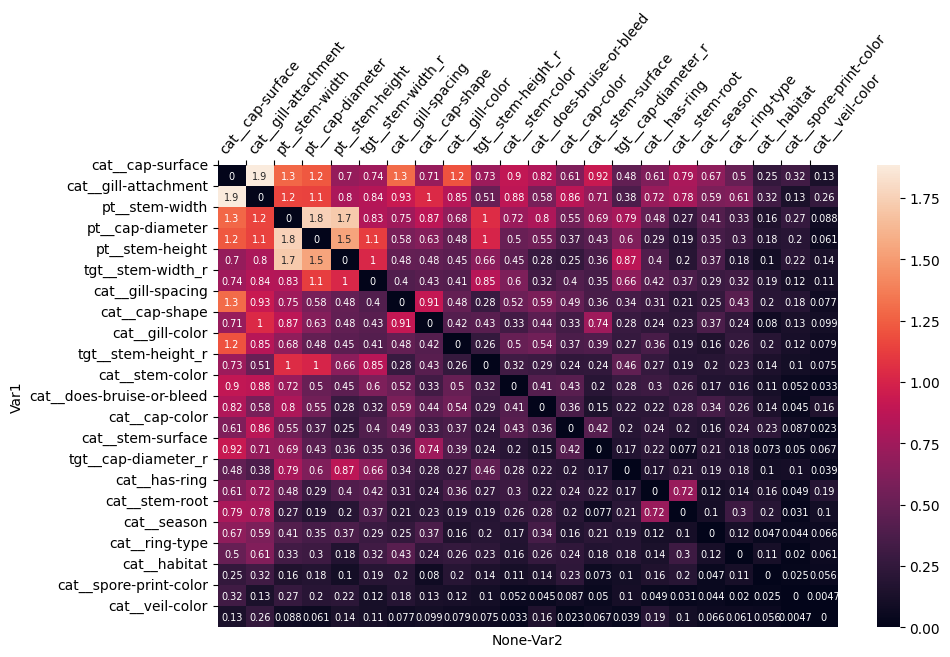

In [46]:
df_cb_inter = pd.concat([
    result_tgt['model_result'][1],
    result_tgt['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
sns.heatmap(df_cb_inter, annot=True, annot_kws={'size': 7})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

## 수치형 변수의 구간화

In [47]:
X_tgt = ['stem-width', 'cap-diameter', 'stem-height']
hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num'), 'X_cat': cbt.get_vars('cat') + [i + '_q' for i in X_tgt],
    'validation_fraction': 0.1, 
}
result_q = sc.cache_result(
    'cb_quan',
    lambda : sgml.cv(
        dproc.join_and_assign(
            df_ml, 
            pd.concat([pd.qcut(df_ml[i], q=100, labels=np.arange(100)).rename(i + '_q') for i in X_tgt], axis=1)
        ), ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result_q['train_scores'], result_q['valid_scores']

([0.9845241941839609], [0.983652663309855])

In [48]:
result_q['model_result'][0]['feature_importance'].sort_values(ascending = False)

cat__gill-attachment         15.509582
cat__cap-surface             14.534181
cat__stem-color              12.610063
cat__gill-color               7.369492
pt__stem-width                5.801111
cat__gill-spacing             5.787112
cat__stem-surface             5.713622
cat__cap-color                5.307218
cat__stem-width_q             3.634075
cat__stem-root                3.458968
cat__cap-shape                3.428847
cat__season                   3.375106
cat__ring-type                2.291123
cat__does-bruise-or-bleed     2.276538
cat__stem-height_q            2.195396
pt__cap-diameter              1.888948
cat__cap-diameter_q           1.237796
pt__stem-height               1.126676
cat__habitat                  1.104135
cat__has-ring                 0.832911
cat__veil-color               0.218079
cat__spore-print-color        0.191180
cat__veil-type                0.107839
dtype: float64

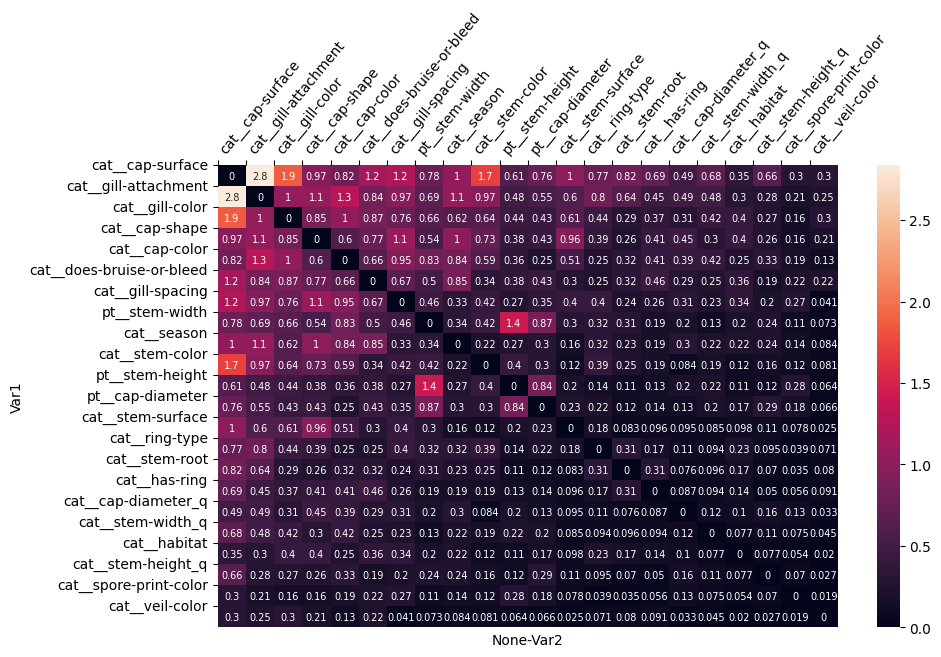

In [49]:
df_cb_inter = pd.concat([
    result_q['model_result'][1],
    result_q['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
sns.heatmap(df_cb_inter, annot=True, annot_kws={'size': 7})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

## 수치형 변수의 구간화 2

In [50]:
from sklearn.preprocessing import KBinsDiscretizer

kbd = KBinsDiscretizer(300, strategy = 'kmeans', encode = 'ordinal').set_output(transform='pandas')
X_tgt = ['stem-width', 'cap-diameter', 'stem-height']
hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num'), 'X_cat': cbt.get_vars('cat') + [i + '_q2' for i in X_tgt],
    'validation_fraction': 0.1, 
}
result_qk = sc.cache_result(
    'cb_quank',
    lambda : sgml.cv(
        dproc.join_and_assign(
            df_ml, 
            kbd.fit_transform(df_ml[cbt.get_vars('num')]).astype('int').rename(columns=lambda x: x + '_q2')
        ), ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result_qk['train_scores'], result_qk['valid_scores']

([0.984535888852824], [0.9837526938540203])

## 수치형 변수의 범주로 간주

In [51]:
from sklearn.preprocessing import KBinsDiscretizer

hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num'), 'X_cat': cbt.get_vars('cat') + [i + '_s' for i in X_tgt],
    'validation_fraction': 0.1, 'combination_ctr' : 'CtrBorderCount=2', 'simple_ctr': 'CtrBorderCount=2'
}
result_ntc = sc.cache_result(
    'cb_num_to_cat',
    lambda : sgml.cv(
        dproc.join_and_assign(
            df_ml, 
            pd.concat([
                dproc.replace_cat(df_ml[i].astype('category'), lambda x: str(x)).rename(i + '_s')
                for i in X_tgt
            ], axis=1)
        ), ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result_ntc['train_scores'], result_ntc['valid_scores']

([0.9844809512268596], [0.9834710296277845])

### + combination cap-surface, gill-attachment

In [52]:
kbd = KBinsDiscretizer(300, strategy = 'kmeans', encode = 'ordinal').set_output(transform='pandas')
hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num'), 'X_cat': cbt.get_vars('cat') + [i + '_q2' for i in cbt.get_vars('num')] + ['comb_1'],
    'validation_fraction': 0.1, 
}
result_q2 = sc.cache_result(
    'cb_quan_combine',
    lambda : sgml.cv(
        dproc.join_and_assign(
            df_ml, 
            kbd.fit_transform(df_ml[cbt.get_vars('num')]).astype('int').rename(columns=lambda x: x + '_q2').join(
                dproc.combine_cat(df_ml[['cap-surface', 'gill-attachment']]).rename('comb_1')
            )
        ), ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result_q2['train_scores'], result_q2['valid_scores']

([0.9845470607252294], [0.9836479106920132])

### + Combination cap-surface, cap-shape, gill-attachment, gill-color, gill-spacing

In [53]:
kbd = KBinsDiscretizer(300, strategy = 'kmeans', encode = 'ordinal').set_output(transform='pandas')
hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num'), 'X_cat': cbt.get_vars('cat') + [i + '_q2' for i in cbt.get_vars('num')] + ['comb_2'],
    'validation_fraction': 0.1,  'combination_ctr' : 'CtrBorderCount=7', 'simple_ctr': 'CtrBorderCount=7'
}
result_q3 = sc.cache_result(
    'cb_quan_combine2',
    lambda : sgml.cv(
        dproc.join_and_assign(
            df_ml, 
            kbd.fit_transform(df_ml[cbt.get_vars('num')]).astype('int').rename(columns=lambda x: x + '_q2').join(
                dproc.combine_cat(df_ml[['cap-surface', 'cap-shape', 'gill-attachment', 'gill-color', 'gill-spacing']]).rename('comb_2')
            )
        ), ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result_q3['train_scores'], result_q3['valid_scores']

([0.9854218682911404], [0.9836652541605877])

In [54]:
result_q3['model_result'][0]['feature_importance'].sort_values(ascending = False)

cat__comb_2                  28.826151
cat__stem-surface             8.652822
cat__stem-width_q             7.460363
cat__stem-root                6.746735
cat__stem-color               6.653791
cat__cap-color                4.682385
cat__does-bruise-or-bleed     4.513724
cat__gill-attachment          3.816621
cat__stem-height_q            3.404022
cat__season                   3.126949
cat__cap-surface              2.741661
cat__cap-diameter_q           2.416932
pt__stem-width                2.327388
cat__gill-spacing             2.111459
cat__cap-shape                2.024821
cat__gill-color               1.894226
pt__cap-diameter              1.871883
cat__ring-type                1.698298
cat__habitat                  1.507062
cat__has-ring                 1.366282
pt__stem-height               1.156366
cat__veil-color               0.481704
cat__spore-print-color        0.467203
cat__veil-type                0.051151
dtype: float64

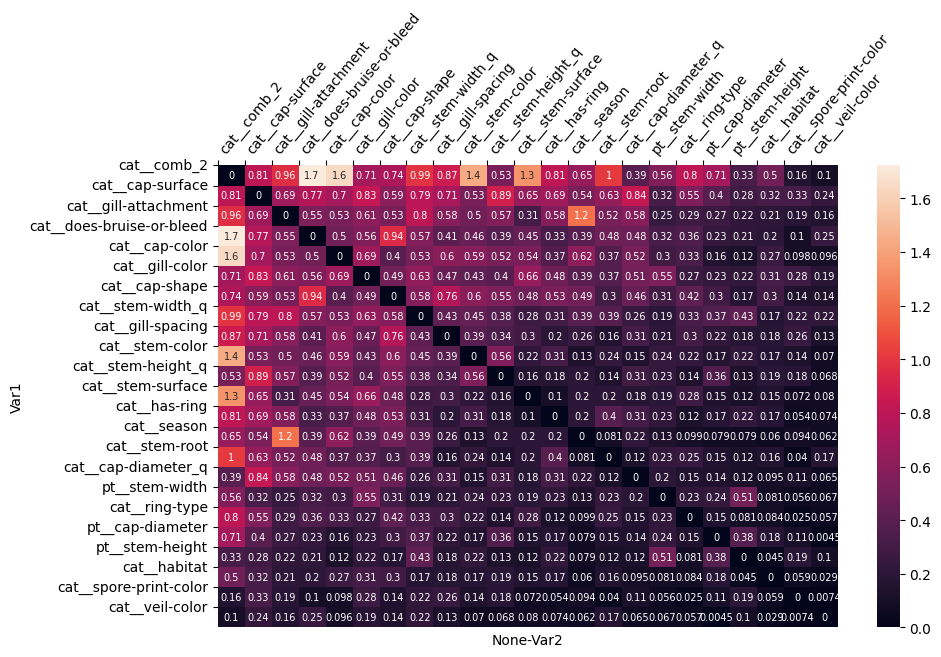

In [55]:
df_cb_inter = pd.concat([
    result_q3['model_result'][1],
    result_q3['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
sns.heatmap(df_cb_inter, annot=True, annot_kws={'size': 7})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

### + cap-* , + gill-* , +stem-*

In [56]:
kbd = KBinsDiscretizer(300, strategy = 'kmeans', encode = 'ordinal').set_output(transform='pandas')
hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num'), 'X_cat': cbt.get_vars('cat') + [i + '_q2' for i in X_tgt] + ['cap', 'gill', 'stem'],
    'validation_fraction': 0.1,  'combination_ctr' : 'CtrBorderCount=7', 'simple_ctr': 'CtrBorderCount=7'
}
result_q4 = sc.cache_result(
    'cb_quan_combine3',
    lambda : sgml.cv(
        dproc.join_and_assign(
            df_ml, 
            kbd.fit_transform(df_ml[cbt.get_vars('num')]).astype('int').rename(columns=lambda x: x + '_q2').join(
                sgpp.CatCombiner([
                    (['cap-surface', 'gill-attachment', 'gill-color'], 'cap'),
                    (['gill-attachment', 'gill-color', 'gill-spacing'], 'gill'),
                    (['stem-surface', 'stem-color', 'stem-root'], 'stem')
                ]).fit_transform(df_ml[X_cat])
            )
        ), ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 1
)
result_q4['train_scores'], result_q4['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

([0.9848817848191774], [0.9837649168550171])

In [57]:
result_q4['model_result'][0]['feature_importance'].sort_values(ascending = False)

cat__cap                     17.167197
cat__stem                    16.276252
cat__gill                    15.624132
cat__stem-width_q2            5.720732
cat__cap-surface              5.656306
cat__gill-spacing             4.607349
cat__cap-color                4.076175
cat__cap-shape                3.560352
cat__does-bruise-or-bleed     3.161755
cat__stem-height_q2           2.889991
cat__cap-diameter_q2          2.715277
cat__season                   2.688883
cat__gill-attachment          2.631396
cat__stem-surface             1.767285
cat__stem-color               1.751399
cat__ring-type                1.521191
pt__cap-diameter              1.406912
pt__stem-width                1.111076
cat__habitat                  1.102062
cat__gill-color               1.080475
pt__stem-height               0.982689
cat__has-ring                 0.971733
cat__stem-root                0.851104
cat__spore-print-color        0.340286
cat__veil-color               0.315268
cat__veil-type           

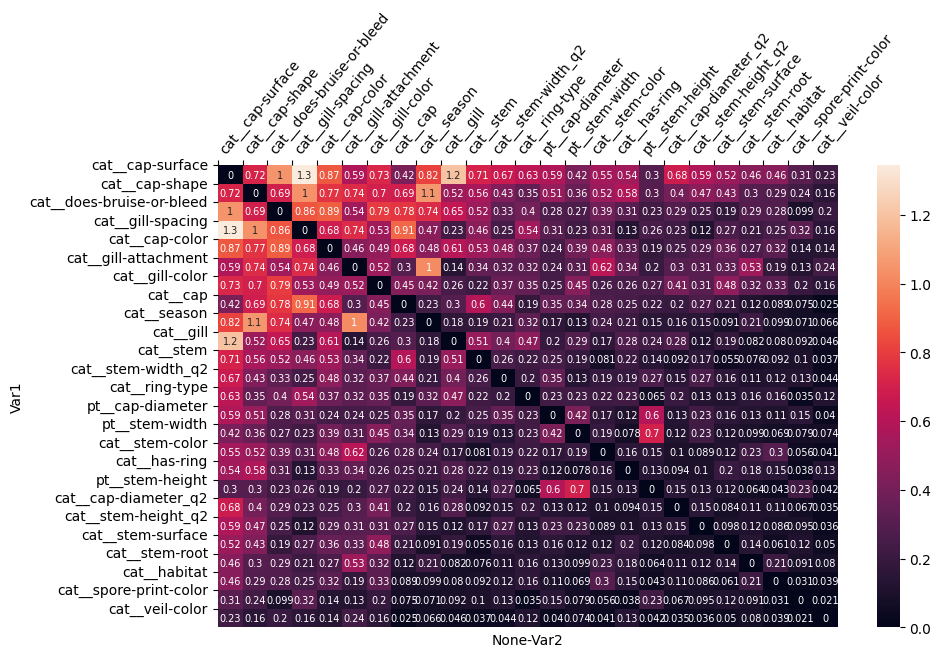

In [58]:
df_cb_inter = pd.concat([
    result_q4['model_result'][1],
    result_q4['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
sns.heatmap(df_cb_inter, annot=True, annot_kws={'size': 7})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

## Ratio

In [59]:
from sklearn.preprocessing import FunctionTransformer
ct_ratio = ColumnTransformer([
    ('r1', FunctionTransformer(lambda x: (x.iloc[:, 0] / x.iloc[:, 1].clip(0.44)).rename('_'.join(x.columns)).to_frame(), feature_names_out = lambda x, y: [y[0] + '_' + y[1]]), ['stem-width', 'stem-height']),
    ('r2', FunctionTransformer(lambda x: (x.iloc[:, 0] / x.iloc[:, 1].clip(0.44)).rename('_'.join(x.columns)).to_frame(), feature_names_out = lambda x, y: [y[0] + '_' + y[1]]), ['stem-width', 'cap-diameter']),
    ('r3', FunctionTransformer(lambda x: (x.iloc[:, 0] / x.iloc[:, 1].clip(0.44)).rename('_'.join(x.columns)).to_frame(), feature_names_out = lambda x, y: [y[0] + '_' + y[1]]), ['stem-height', 'cap-diameter']),
]).set_output(transform='pandas').fit(df_ml)
ct_ratio.get_feature_names_out()

array(['r1__stem-width_stem-height', 'r2__stem-width_cap-diameter',
       'r3__stem-height_cap-diameter'], dtype=object)

In [60]:
hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num') + ct_ratio.get_feature_names_out().tolist(), 'X_cat': cbt.get_vars('cat'),
    'validation_fraction': 0.1, 
}
result_ratio = sc.cache_result(
    'cb_ratio',
    lambda : sgml.cv(
        dproc.join_and_assign(
            df_ml, ct_ratio.transform(df_ml)
        ), ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result_ratio['train_scores'], result_ratio['valid_scores']

([0.9838232688172946], [0.9833466134941664])

## Class Weighting

In [61]:
X_size = ['stem-width', 'cap-diameter', 'stem-height']

hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123, 'class_weights' : {0: 1, 1: 1.5}},
    'X_num': cbt.get_vars('num'), 'X_cat': cbt.get_vars('cat'),
    'validation_fraction': 0.1, 
}
result_wt = sc.cache_result(
    'cb_class_weight',
    lambda : sgml.cv(
        df_ml, ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result_wt['train_scores'], result_wt['valid_scores']

([0.983564366879943], [0.9830748113080551])

In [62]:
confusion_matrix(df_ml.loc[result_wt['valid_prd'].index, target], result_wt['valid_prd'] >= 0.5)

array([[559622,   5093],
       [  5365, 676698]])

## 버섯의 크기 정규화

In [63]:
cbt.get_vars('num')
X_size = ['stem-width', 'cap-diameter', 'stem-height']

hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num') + [i + '_n' for i in X_size], 'X_cat': cbt.get_vars('cat'),
    'validation_fraction': 0.1, 
}
result_norm = sc.cache_result(
    'cb_size',
    lambda : sgml.cv(
        dproc.join_and_assign(
            df_ml, df_ml[X_size].divide(((df_ml[X_size] ** 2).sum(axis=1) ** 0.5), axis = 0).rename(columns = lambda x: x + '_n')
        ), ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result_norm['train_scores'], result_norm['valid_scores']

([0.9838536284921657], [0.9833436641785999])

## Spore-print-color 보간

Spore-print-color가 결측이 90% 이고 결측 여부에 따라 Cross Entropy가 높습니다. 결측 보간을 시도해보고 효과성을 확인해봅니다.

In [64]:
from sklearn.model_selection import cross_validate, StratifiedKFold

sc.cache_result(
    'spore-print-color-imp-cv',
    lambda : df_ml.loc[df_ml['spore-print-color'] != 'Unk'].pipe(
        lambda x: cross_validate(
            lgb.LGBMClassifier(verbose = -1, random_state = 123, ), 
            x[[i for i in cbt.get_vars('cat') if i != 'spore-print-color'] + cbt.get_vars('num')], x['spore-print-color'],
            scoring = 'accuracy', cv = StratifiedKFold(5, random_state = 123, shuffle = True), return_train_score = True
        )
    ), rerun = 0
)

{'fit_time': array([1.86957431, 1.75070977, 1.76200175, 1.78179049, 2.38785028]),
 'score_time': array([0.34096146, 0.33888173, 0.33632636, 0.34221339, 0.40333986]),
 'test_score': array([0.91848914, 0.90904159, 0.91925617, 0.91480207, 0.91916112]),
 'train_score': array([0.93415182, 0.92507834, 0.93250082, 0.92756687, 0.93280514])}

In [65]:
sc.cache_result(
    'spore-print-color-imp-ss',
    lambda : df_ml.loc[df_ml['spore-print-color'] != 'Unk'].pipe(
        lambda x: cross_validate(
            lgb.LGBMClassifier(verbose = -1, random_state = 123, n_estimators = 200, learning_rate = 0.008), 
            x[[i for i in cbt.get_vars('cat') if i != 'spore-print-color'] + cbt.get_vars('num')], x['spore-print-color'],
            scoring = 'accuracy', cv = ss, 
            return_train_score = True
        )
    ), rerun = 0
)

{'fit_time': array([2.60596061]),
 'score_time': array([1.12895393]),
 'test_score': array([0.92676744]),
 'train_score': array([0.93387878])}

In [66]:
imp = sc.cache_result(
    'imp_model',
    lambda : sgpp.LGBMImputer(
        lgb.LGBMClassifier, {'random_state': 123, 'n_estimators': 200, 'learning_rate': 0.008}, 
        cbt.get_vars('num'),  [i for i in cbt.get_vars('cat') if i != 'spore-print-color'],
        'spore-print-color', 'Unk'
    ).fit(pd.concat([
        df_ml[cbt.get_vars('num') + cbt.get_vars('cat')],
        df_ml_test[cbt.get_vars('num') + cbt.get_vars('cat')]
    ]))
)
df_ml['spore-print-color_s'] = sc.cache_result(
    'imp_transform',
    lambda : imp.transform(df_ml).rename(columns = lambda x: x + '_s')
)

In [67]:
hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num'), 'X_cat': [i for i in cbt.get_vars('cat') if i != 'spore-print-color'] + ['spore-print-color_s'],
    'validation_fraction': 0.1, 
}
result_imp1 = sc.cache_result(
    'cb_imp',
    lambda : sgml.cv(
        df_ml, ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result_imp1['train_scores'], result_imp1['valid_scores']

([0.9837952259473873], [0.9833433890287749])

## gill-attachment보간

중요도가 높은 속성인 만큼 보간을 시도해봅니다.

In [68]:
from sklearn.model_selection import cross_validate, StratifiedKFold

sc.cache_result(
    'gill-attachment-imp-cv',
    lambda : df_ml.loc[df_ml['gill-attachment'] != 'Unk'].pipe(
        lambda x: cross_validate(
            lgb.LGBMClassifier(verbose = -1, random_state = 123, ), 
            x[[i for i in cbt.get_vars('cat') if i != 'gill-attachment'] + cbt.get_vars('num')], x['gill-attachment'],
            scoring = 'accuracy', cv = StratifiedKFold(5, random_state = 123, shuffle = True), return_train_score = True
        )
    ), rerun = 0
)

{'fit_time': array([26.40832543, 26.41656256, 27.20642042, 27.64830446, 26.58861113]),
 'score_time': array([3.93384552, 4.68066669, 4.34248686, 4.38746905, 4.59997034]),
 'test_score': array([0.96879881, 0.96930016, 0.96928859, 0.96931365, 0.96952185]),
 'train_score': array([0.96967133, 0.97006036, 0.97021655, 0.97008543, 0.9703607 ])}

In [69]:
sc.cache_result(
    'gill-attachment-imp-ss',
    lambda : df_ml.loc[df_ml['gill-attachment'] != 'Unk'].pipe(
        lambda x: cross_validate(
            lgb.LGBMClassifier(verbose = -1, random_state = 123, n_estimators = 100, learning_rate = 0.07), 
            x[[i for i in cbt.get_vars('cat') if i != 'gill-attachment'] + cbt.get_vars('num')], x['gill-attachment'],
            scoring = 'accuracy', cv = ss, 
            return_train_score = True
        )
    ), rerun = 0
)

{'fit_time': array([20.75030684]),
 'score_time': array([8.83643794]),
 'test_score': array([0.96921339]),
 'train_score': array([0.9698709])}

In [70]:
imp = sc.cache_result(
    'imp_model2',
    lambda : sgpp.LGBMImputer(
        lgb.LGBMClassifier, {'random_state': 123, 'n_estimators': 100, 'learning_rate': 0.07}, 
        cbt.get_vars('num'),  [i for i in cbt.get_vars('cat') if i != 'gill-attachment'],
        'gill-attachment', 'Unk'
    ).fit(pd.concat([
        df_ml[cbt.get_vars('num') + cbt.get_vars('cat')],
        df_ml_test[cbt.get_vars('num') + cbt.get_vars('cat')]
    ]))
)
df_ml['gill-attachment_s'] = sc.cache_result(
    'imp_transform2',
    lambda : imp.transform(df_ml).rename(columns = lambda x: x + '_s')
)

In [71]:
hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num'), 'X_cat': [i for i in cbt.get_vars('cat')] + ['gill-attachment_s'],
    'validation_fraction': 0.1, 
}
result_imp2 = sc.cache_result(
    'cb_imp2',
    lambda : sgml.cv(
        df_ml, ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result_imp2['train_scores'], result_imp2['valid_scores']

([0.9837218354124168], [0.9833031082332901])

## Iterative imputing

In [72]:
imp_targets = ['cap-surface', 'stem-surface', 'veil-color', 'spore-print-color', 'gill-attachment', 'veil-type', 'gill-spacing']
lgb_imp = sc.cache_result(
    'iter_imp',
    lambda : sgpp.LGBMIterativeImputer(
        hparams = {'n_estimators': 200},
        X_num = cbt.get_vars('num'),
        X_cat = cbt.get_vars('cat'),
        targets = imp_targets,
        na_value = 'Unk', 
        hparams_dic = {'spore-print-color': {'n_estimators': 400, 'learning_rate': 0.05}},
        validation_fraction = 0.1, 
        n_iter = 3
    ).fit(
        pd.concat([
            df_ml[cbt.get_vars()],
            df_ml_test[cbt.get_vars()]
        ], axis = 0)
    ), rerun = 0
)
df_imp = sc.cache_result(
    'df_imp',
    lambda : lgb_imp.transform(df_ml[cbt.get_vars()], n_iter = 2)
)

In [73]:
hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num'), 'X_cat': [i for i in cbt.get_vars('cat')] + [i + '_ii' for i in imp_targets], 
    'validation_fraction': 0.1, 
}
result_ii = sc.cache_result(
    'cb_iter_imp',
    lambda : sgml.cv(
        dproc.join_and_assign(
            df_ml, df_imp.rename(columns = lambda x: x + '_ii')
        ), ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result_ii['train_scores'], result_ii['valid_scores']

([0.9836629208328515], [0.9832905403195301])

## Frequency Encoding

In [74]:
freq_enc = sgpp.FrequencyEncoder()
freq_enc.fit(pd.concat([df_ml[cbt.get_vars('num')], df_ml_test[cbt.get_vars('num')]]))

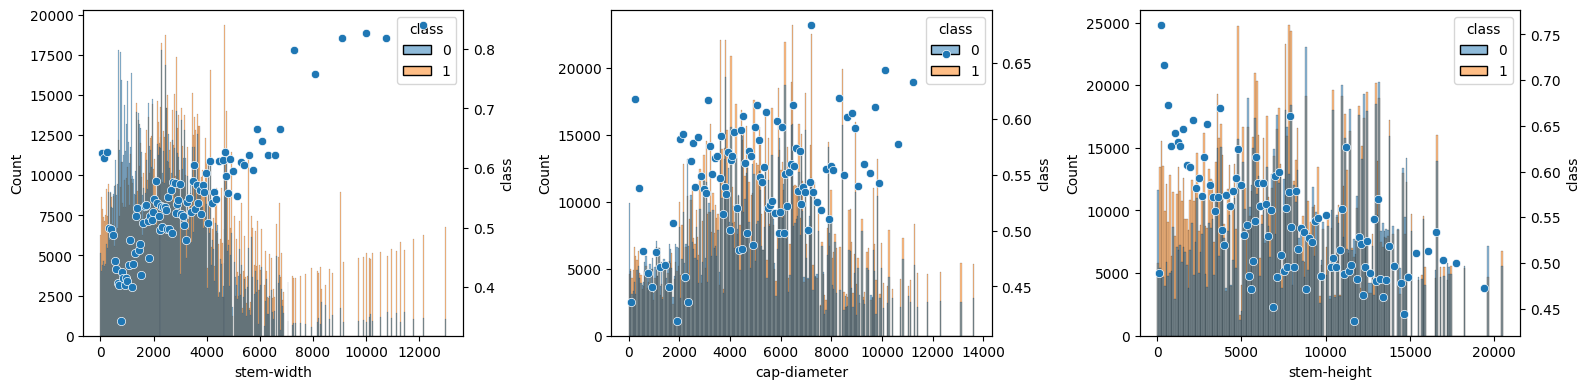

In [75]:
def plot_hist_freq(val, axes):
    df_freq = freq_enc.transform(df_ml[cbt.get_vars('num')])
    for i, ax in zip(val, axes):
        sns.histplot(x = df_freq[i], hue = df_ml[target], ax=ax)
        df_ml.groupby(pd.qcut(df_freq[i], q = 100).map(lambda x: (x.left + x.right) / 2), observed=True)[target].mean().pipe(
            lambda x: sns.scatterplot(x, ax = ax.twinx())
        )
sc.cache_fig(
    'plot_hist_freq_num',
    lambda x: plot_hist_freq(cbt.get_vars('num'), x), 1, 3, figsize = (16, 4), redraw = 1
)

In [76]:
freq_var = [i + '_freq' for i in cbt.get_vars('num')]
hparams = {
    'model_params': {'n_estimators': 2000, 'random_state': 123},
    'X_num': cbt.get_vars('num') + freq_var, 'X_cat': cbt.get_vars('cat'),
    'validation_fraction': 0.1, 
}
result_freq = sc.cache_result(
    'cb_freq',
    lambda : sgml.cv(
        dproc.join_and_assign(
            df_ml, freq_enc.transform(df_ml[cbt.get_vars('num')]).rename(columns = lambda x: x + '_freq')
        ), ss, hparams, config, cb_adapter, 
        result_proc=[
            sgml.cb_learning_result, 
            sgml.cb_interaction_importance
        ],
        task_type = 'GPU'
    ), rerun = 0
)
result['train_scores'], result['valid_scores']

([0.972734320857262], [0.9729621111575812])

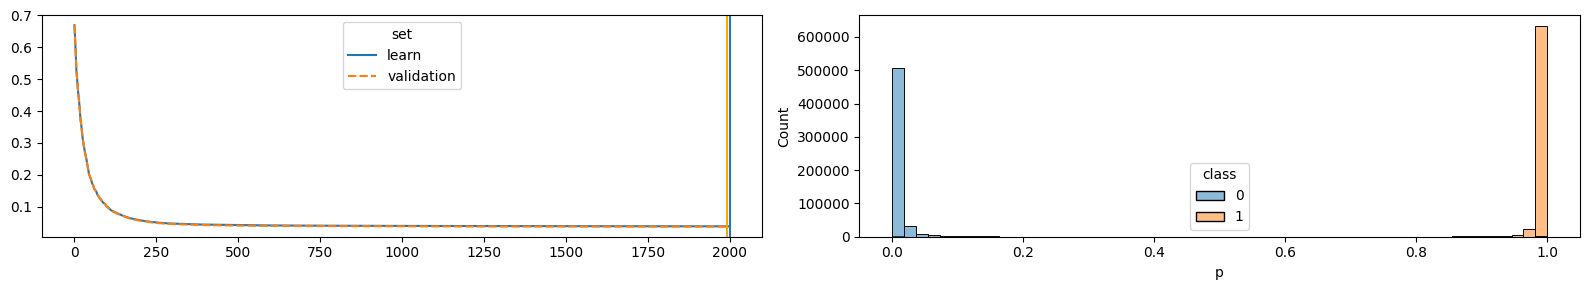

In [77]:
fig, axes= plt.subplots(1, 2, figsize = (16, 3))
sns.lineplot(
    result_freq['model_result'][0]['valid_result'].T.reset_index(level=0, drop=True).T, ax = axes[0]
)
axes[0].axvline(result_freq['model_result'][0]['valid_result'].idxmin().iloc[0])
axes[0].axvline(result_freq['model_result'][0]['valid_result'].idxmin().iloc[1], color = 'orange')

sns.histplot(
    x = result_freq['valid_prd'], hue = df_ml.loc[result_freq['valid_prd'].index, target], ax = axes[1]
)
plt.tight_layout()
plt.show()

In [78]:
result_freq['model_result'][0]['feature_importance'].sort_values(ascending = False)

cat__gill-attachment         11.511280
pt__stem-width               10.715565
cat__cap-surface             10.247381
cat__gill-spacing             9.484113
cat__stem-surface             8.439200
cat__stem-color               8.067575
pt__stem-height               5.706172
cat__gill-color               5.239336
cat__does-bruise-or-bleed     4.611422
cat__stem-root                4.090146
pt__cap-diameter              4.083663
cat__cap-color                3.949098
cat__cap-shape                3.863190
cat__ring-type                2.346134
cat__season                   1.936963
cat__has-ring                 1.851919
cat__habitat                  1.309402
pt__stem-height_freq          1.031180
cat__veil-type                0.474108
pt__stem-width_freq           0.425016
cat__veil-color               0.256618
cat__spore-print-color        0.181751
pt__cap-diameter_freq         0.178770
dtype: float64

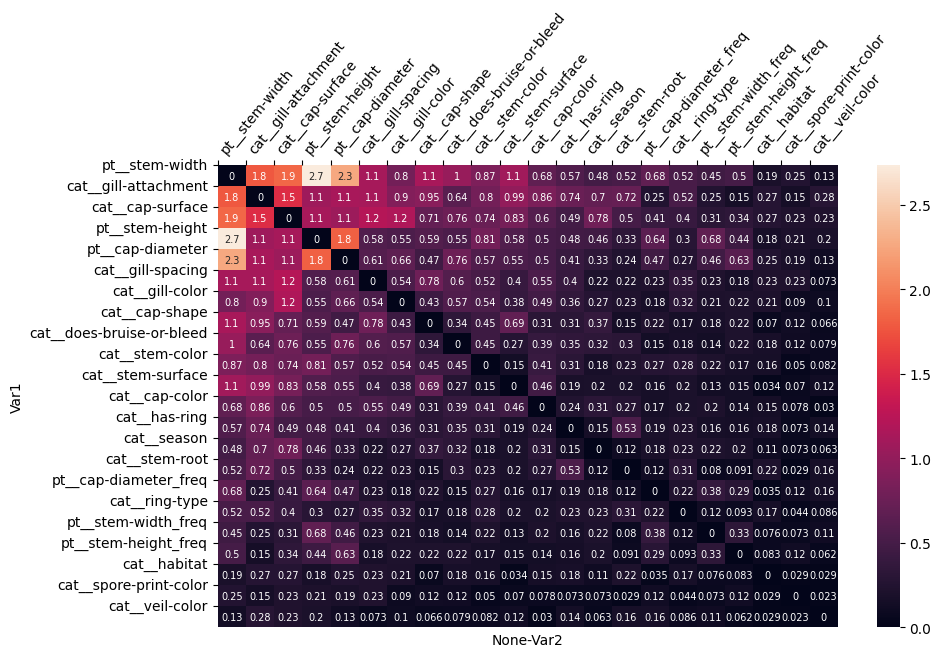

In [79]:
df_cb_inter = pd.concat([
    result_freq['model_result'][1],
    result_freq['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
sns.heatmap(df_cb_inter, annot=True, annot_kws={'size': 7})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

In [80]:
df_prds = pd.concat(
    [i['valid_prd'].rename(name) for name, i in zip(
        ['baseline', 'tgt', 'wt', 'norm', 'imp1', 'imp2', 'ii', 'freq', 'q', 'q2', 'q3', 'q4', 'ratio'],
        [result_base, result_tgt, result_wt, result_norm, result_imp1, result_imp2, result_ii, result_freq, result_q, result_qk, result_q3, result_q4, result_ratio],
    )],
    axis = 1
)
df_prds.corr()

,baseline,tgt,wt,norm,imp1,imp2,ii,freq,q,q2,q3,q4,ratio
baseline,1.000000,0.999755,0.999714,0.999720,0.999874,0.999882,0.999779,0.999891,0.999384,0.999342,0.998806,0.999043,0.999699
tgt,0.999755,1.000000,0.999543,0.999637,0.999702,0.999713,0.999645,0.999737,0.999359,0.999341,0.998729,0.999005,0.999603
wt,0.999714,0.999543,1.000000,0.999526,0.999651,0.999665,0.999586,0.999683,0.999186,0.999131,0.998526,0.998803,0.999514
norm,0.999720,0.999637,0.999526,1.000000,0.999698,0.999699,0.999629,0.999715,0.999236,0.999200,0.998680,0.998922,0.999826
imp1,0.999874,0.999702,0.999651,0.999698,1.000000,0.999845,0.999750,0.999856,0.999351,0.999303,0.998795,0.999035,0.999678
imp2,0.999882,0.999713,0.999665,0.999699,0.999845,1.000000,0.999777,0.999873,0.999322,0.999268,0.998750,0.998987,0.999676
ii,0.999779,0.999645,0.999586,0.999629,0.999750,0.999777,1.000000,0.999762,0.999276,0.999226,0.998685,0.998933,0.999622
freq,0.999891,0.999737,0.999683,0.999715,0.999856,0.999873,0.999762,1.000000,0.999358,0.999316,0.998770,0.999016,0.999686
q,0.999384,0.999359,0.999186,0.999236,0.999351,0.999322,0.999276,0.999358,1.000000,0.999808,0.999233,0.999400,0.999231
q2,0.999342,0.999341,0.999131,0.999200,0.999303,0.999268,0.999226,0.999316,0.999808,1.000000,0.999190,0.999456,0.999183


In [81]:
matthews_corrcoef(
    df_ml.loc[df_prds.index, target], 
    df_prds.mean(axis = 1) >= 0.5
)

0.9837300513329095

In [82]:
matthews_corrcoef(
    df_ml.loc[df_prds.index, target], 
    df_prds[['ratio', 'q', 'q3', 'q4']].mean(axis = 1) >= 0.5
)

0.9840916911162181

# Compose Processing

In [ ]:
('q', ['stem-width', 'cap-diameter', 'stem-height']),